<a href="https://colab.research.google.com/github/YovliDuvshani/RideHailling/blob/main/Commun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import 

!pip install pyhailing
!pip install --upgrade Pillow # Restart runtime

import torch.nn as nn
import torch
import numpy
import numpy as np #To improve
import pyhailing
from pyhailing import RidehailEnv
import tqdm
import random
from collections import OrderedDict
import time as t
import torch.nn.functional as F
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pickle
import time as __time__

random.seed(0)
torch.manual_seed(0)
numpy.random.seed(0)
device = torch.device("cpu") #torch.device('cuda')

## Distance functions

In [ ]:
env = RidehailEnv()
speeds_data = env.speeds_data.reset_index()

In [ ]:
def dist_manhattan(list_coord_depart, list_coord_arrivee):
  """ Retourne la distance de Manhattan entre deux points d'un plan 
  Prend en entrée les coordonnées des points de départ et d'arrivée :
  ([x_depart,y_depart],[x_arrivee,y_arrivee]) """
  
  depart = numpy.array(list_coord_depart)
  arrivee = numpy.array(list_coord_arrivee)
  return numpy.linalg.norm((depart - arrivee), ord=1)

In [ ]:
def vitesse_normalisee(vitesse_moyenne, sigma):
  """ Retourne un tirage aléatoire d'une loi normale N(vitesse_moyenne,variance_vitesse) """
  
  #return numpy.random.randn(1)*sigma + vitesse_moyenne
  loi_normale = numpy.random.randn(1000)
  loi_normale = [loi_normale[i]*sigma + vitesse_moyenne for i in range(len(loi_normale))]
  limite = numpy.quantile(loi_normale, .10)
  normale_tronquee = []
  for i in range(len(loi_normale)):
    loi_normale[i] = numpy.array(loi_normale[i])[0]
    if loi_normale[i] >= limite:
      normale_tronquee.append(loi_normale[i])
  return random.choices(normale_tronquee)[0]

In [ ]:
def duree_deplacement(list_coord_depart, list_coord_arrivee, time_):
  """ Retourne la duree d'un trajet en secondes
  Prend en entrée les coordonnées des points de départ et d'arrivée ainsi que l'heure :
  ([x_depart,y_depart],[x_arrivee,y_arrivee],time) """

  distance = dist_manhattan(list_coord_depart, list_coord_arrivee)
  depart = numpy.array(list_coord_depart)
  arrivee = numpy.array(list_coord_arrivee)
  zone_depart = env.xy_to_zone(depart)
  zone_arrivee = env.xy_to_zone(arrivee)
  tranche_horaire = int(time_/15/60)*15
  vitesse_moyenne = speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_mean']
  sigma = speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_stddev']
  #vitesse_associee = vitesse_normalisee(vitesse_moyenne, sigma) #WAY TO MUCH TIME TO PROCESS
  temps = distance/vitesse_moyenne
  return numpy.array(temps)

In [ ]:
def distance_to_request(car_coord, req_coord, car_job, time, first_job_coord, second_job_coord, third_job_coord): #A revoir + Prendre en compte les plages horaires. #Vérifier sur exemple.
  """
  Return the distance to a request taking into account the jobs of the cars. #Distance -> Time
  """

  car_job = str(car_job[0]) + str(car_job[1]) + str(car_job[2])
  if car_job in ['044','444','104']: 
    return duree_deplacement(car_coord,req_coord,time)
  if car_job in ['344']:
    duree = duree_deplacement(car_coord,first_job_coord[1],time)
    duree += duree_deplacement(first_job_coord[1],req_coord,(time+duree)%86400)
    return duree
  if car_job == '234':
    duree = duree_deplacement(car_coord,first_job_coord[1],time) 
    duree += duree_deplacement(first_job_coord[1],second_job_coord[0],(time+duree)%86400)
    duree += duree_deplacement(second_job_coord[0],second_job_coord[1],(time+duree)%86400)
    duree += duree_deplacement(second_job_coord[1],req_coord,(time+duree)%86400)
    return duree
  duree = duree_deplacement(car_coord,first_job_coord[1],time) 
  duree += duree_deplacement(first_job_coord[1],second_job_coord[0],(time+duree)%86400)
  duree += duree_deplacement(second_job_coord[0],second_job_coord[1],(time+duree)%86400)
  duree += duree_deplacement(second_job_coord[1],third_job_coord[0],(time+duree)%86400)
  duree += duree_deplacement(third_job_coord[0],third_job_coord[1],(time+duree)%86400)
  duree += duree_deplacement(third_job_coord[1],req_coord,(time+duree)%86400)
  return duree

## Environment

In [ ]:
def triplets_jobs(state): #Statut
  """ Prend en entrée l'état de l'environnement et retourne les listes des indices des véhicules pour chaque
  triplet de jobs sous forme d'une liste de listes ayant chaucune le triplet en premier élément 
  """
  jobs = state['v_jobs']
  dic = {'044':[],'104':[],'234':[],'323':[],'344':[],'444':[]}
  for i in range(len(jobs)):
    triplet = str(jobs[i][0]) + str(jobs[i][1]) + str(jobs[i][2])
    dic[triplet] += [i]
  return dic

In [ ]:
# Coordonate normalization
estimated_mean_x = 587.89
estimated_sigma_x = 0.94
estimated_mean_y = 4512.1
estimated_sigma_y = 3.21
def normalize_x(x):
  return (x-estimated_mean_x)/estimated_sigma_x
def normalize_y(y):
  return (y-estimated_mean_y)/estimated_sigma_y



### Probas par jour par tranche horaire par zone

In [ ]:
def coef_env_reel(int):
  return int*6.316478902436049e-05/1400

df_per_day = [env.trips_data[env.trips_data['dow']==i] for i in range(5)]
requests_indexes = [0,0,0,0,0]
for i in range(5):
  df_per_day[i].rename(columns = {'dow':'day', 'puzone':'zone_dep', 'dozone':'zone_arr', 'n_trips':'proba_req'}, inplace = True)
  df_per_day[i]['proba_req'] = df_per_day[i]['proba_req'].map(coef_env_reel)

day = 0 # state['dow']
df_per_day[day]

,day,t_15min,zone_dep,zone_arr,proba_req
0,0,0,4,4,6.767656e-07
1,0,0,4,13,2.255885e-07
2,0,0,4,24,9.023541e-08
3,0,0,4,41,1.804708e-07
4,0,0,4,42,7.218833e-07
...,...,...,...,...,...
315277,0,95,263,244,1.714473e-06
315278,0,95,263,246,9.023541e-08
315279,0,95,263,249,7.218833e-07
315280,0,95,263,261,9.023541e-08


### Nb de requêtes par tranche horaire pour un jour non différencié

In [ ]:
tranches_reelles = []
for i in range(96):
  tranches_reelles.append(env.trips_data[env.trips_data['t_15min']==i]['n_trips'].sum())
tranches = pd.DataFrame(data = {'t_15min' : env.trips_data['t_15min'].unique(),
                     'nb_req' : [tranches_reelles[i]*6.316478902436049e-05/5 for i in range(len(tranches_reelles))]})
tranches

,t_15min,nb_req
0,0,9.334493
1,1,8.021271
2,2,6.889118
3,3,5.980632
4,4,5.264949
...,...,...
91,91,17.639601
92,92,16.797299
93,93,15.365100
94,94,14.115549


In [81]:
request_freq = np.load('requests_count.npy')
tranches = pd.DataFrame(data=np.transpose([np.array(range(96)),request_freq]),columns=['t_15min','nb_req'])
tranches

,t_15min,nb_req
0,0,3
1,1,1
2,2,2
3,3,2
4,4,3
...,...,...
91,91,6
92,92,2
93,93,6
94,94,10


In [ ]:
tranches['nb_req'].sum()

1401.4101648196993

## Heuristic functions

### Basic

In [ ]:
def plus_proche_lot(coords_voiture, time):
  """ Retourne l'indice du lot le plus proche, prend en entrée la liste des coordonnées du véhicule d'intérêt
  [x,y] et l'heure 
  """
  lots = numpy.array(env.lots)
  durees = []
  for i in range(len(lots)):
    durees.append(duree_deplacement(coords_voiture, lots[i], time)[0])
  return np.argmin(durees)

In [ ]:
def heuristic(state):
  """
  Returns the reposition according to the heuristic used.
  """
  triplets = triplets_jobs(state)
  reposition = [env.num_lots]*env.num_vehicles 
  if len(triplets['444']) > 0:
    for i in range(len(triplets['444'])):
      lot = plus_proche_lot(state['v_locs'][triplets['444'][i]], state['time'])
      reposition[triplets['444'][i]] = lot
  return np.array(reposition) #Créer l'array direct : improve

### Optimized

#### Pre-processing

In [ ]:
# Pre-Processing

def get_middle_areas():
  """
  returns a df with the coordinate of the middle of every zone
  """
  # Echantillonnage pour définition du milieu des zones

  res = []
  x_sampling = np.linspace(env.x_range[0],env.x_range[1],500)
  y_sampling = np.linspace(env.y_range[0],env.y_range[1],500)

  for x in x_sampling:
    for y in y_sampling:
      res += [[x,y,env.xy_to_zone(np.array([x,y]))]]

  res_ = np.array(res)
  res_ord = pd.DataFrame(data = res_,columns=['x','y','zone'])
  res_mid = pd.concat((res_ord.groupby(["zone"]).x.mean(),res_ord.groupby(["zone"]).y.mean()),axis=1)

  return res_mid

def area_depot_association(df_middle_areas):
  """
  Associate a zone with a depot for every timeframe (An upgrade would be a list)
  return: Array of shape nb_timestep*nb_zones with the lot it should relocalize in
  """
  res = np.zeros((96,env.num_zones))
  lots_coordinate = env.lots
  for t in range(0,86400,900):
    for i in range(env.num_zones):
      min = 5000 #Initialize with a very high value
      ind = 0
      for j in range(len(lots_coordinate)):
        temp = duree_deplacement([df_middle_areas.iloc[i]['x'],df_middle_areas.iloc[i]['y']],[lots_coordinate.iloc[j]['x'],lots_coordinate.iloc[j]['y']],t)
        if temp<min:
          min = temp
          ind = j
      res[t//900][i] = ind
  return res

In [ ]:
middle_areas = get_middle_areas()
middle_areas.head(10)

,x,y
zone,,
4.0,590.189379,4509.072555
12.0,587.959225,4505.401131
13.0,586.489266,4506.097941
24.0,586.268110,4517.125268
41.0,587.537828,4517.882324
42.0,588.676181,4520.640389
43.0,587.573234,4515.206915
45.0,589.435272,4506.975981
48.0,586.877926,4512.196217


In [ ]:
# Link between zones number and ranks

def link_num_rank_zone():
  """
  """
  df_res = pd.DataFrame(columns = ['true_zone'])
  for i in range(env.num_zones):
    df_res = df_res.append({'true_zone': middle_areas.iloc[i].name},ignore_index=True)
  return df_res

link_zone = link_num_rank_zone()

In [ ]:
# Save the file containing the closest depot of every area center (need 2h to compute) 
recreate = False

if recreate:
  area_depot_by_timestep = area_depot_association(middle_areas)
  np.save('area_depot',area_depot_by_timestep)

In [97]:
# Load this file

area_depot_by_timestep = np.load('area_depot.npy')
area_depot_by_timestep

array([[196., 243., 243., ...,  55., 207., 208.],
       [196., 243., 243., ...,  55., 207., 234.],
       [196., 243., 243., ...,  55., 207., 234.],
       ...,
       [ 20., 243., 207., ...,  55., 207., 234.],
       [ 20., 243., 207., ...,  55., 207., 234.],
       [ 20., 243., 207., ...,  55., 207., 234.]])

In [ ]:
# Get a list with every neighbour zone of a location (for every timestep would be better) - In average -> 4 neighbours. -> Save the file because 1h computation time.

if recreate:
  max_time = 240
  nb_zones = env.num_zones
  df_neighbours_every_timestep = pd.DataFrame(columns = ['timestep','zone','neighbours']) 
  for t in range(96):
    for i in range(nb_zones):
      temp = []
      for j in range(nb_zones):
        distance = duree_deplacement([env.lots.iloc[int(area_depot_by_timestep[t][i])]['x'],env.lots.iloc[int(area_depot_by_timestep[t][i])]['y']],[middle_areas.iloc[j]['x'],middle_areas.iloc[j]['y']],t*900)
        if distance < max_time:
          temp_ = link_zone[link_zone['true_zone'] == middle_areas.iloc[j].name].index[0]
          temp += [temp_]
      df_neighbours_every_timestep = df_neighbours_every_timestep.append({'timestep':t,'zone':i,'neighbours':temp},ignore_index=True)
  df_neighbours_every_timestep.to_csv('df_neighbours_every_timestep')

In [101]:
# Load the file

df_neighbours_every_timestep = pd.read_csv('df_neighbours_every_timestep').drop(columns=['Unnamed: 0'])
df_neighbours_every_timestep 

df_neighbours_every_timestep["neighbours"] = df_neighbours_every_timestep["neighbours"].apply(eval)
df_neighbours_every_timestep

,timestep,zone,neighbours
0,0,0,"[13, 16, 18, 19, 20, 31, 32, 41, 44, 45, 50]"
1,0,1,"[1, 14, 59]"
2,0,2,"[1, 14, 59]"
3,0,3,"[3, 33]"
4,0,4,[4]
...,...,...,...
5851,95,56,[55]
5852,95,57,"[10, 42, 50, 57]"
5853,95,58,"[13, 16, 19, 23, 42, 44, 58]"
5854,95,59,"[1, 2, 14, 48, 59]"


#### Heuristic functions

##### Key functions

In [135]:
# Define a Graph class to find the connexe component of our "possibilities"
class Graph():
    def __init__(self, S):
        self.S = S
        self.plus = {}
        self.moins = {}
        self.CFC = {}
        for e in S.keys(): self.CFC[e] = False
    def suiv(self, som):
        return self.S[som]
    def pred(self, som):
        t = []
        for e in self.S.keys():
            if som in self.S[e]:
                t.append(e)
        return t
    def sommets(self):
        return list(self.S.keys())
    def init_mark(self):
        for e in self.S.keys():
            self.plus[e] = self.moins[e] = False

def dfs_suiv(graph, s):
    """
        Parcours DFS des suivants a partir du 
        sommet s
    """
    if graph.plus[s]: return
    graph.plus[s] = True
    for e in graph.suiv(s):
        dfs_suiv(graph, e)
        
def dfs_pred(graph, s):
    """
        Parcours DFS des precedents a partir du 
        sommet s
    """
    if graph.moins[s]: return
    graph.moins[s] = True
    for e in graph.pred(s):
        dfs_pred(graph, e)

def CFC(g):
    composantes = []
    for s in g.sommets(): # pour chaque sommet
        if g.CFC[s]:
            continue # S'il appartient deja a un CFC on le saute
        g.init_mark()
        dfs_suiv(g,s) # propagation des plus
        dfs_pred(g,s) # propagation des moins
        res = []
        for e in g.sommets():
            if g.plus[e] == g.moins[e] == True:
                res.append(e)
                g.CFC[e] = True
        composantes.append(res)
    g.init_mark()
    return composantes

In [191]:
# Heuristique Optimized
# Amélioration : Rajouter l'aspect -> Des requetes vont intervenir entre t et t+delta_t / Classification des requetes en bonnes ou mauvaises.

def available_cars(state,delta_t,time,jobs): #May be interessant to store these durations somehow and update them every time needed.
  """
  returns the available cars at t+delta_t
  """
  available_cars = []
  for car in jobs['044']+ jobs['444']:
    available_cars += [[car,delta_t]]
  for car in jobs['344']+ jobs['104'] :
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time)
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  for car in jobs['234']:
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time) + duree_deplacement(state['v_job_locs'][car][1][0],state['v_job_locs'][car][1][1],time)
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  for car in jobs['323']:
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time) + duree_deplacement(state['v_job_locs'][car][0][1],state['v_job_locs'][car][1][0],time) + duree_deplacement(state['v_job_locs'][car][1][0],state['v_job_locs'][car][1][1],time) + duree_deplacement(state['v_job_locs'][car][2][0],state['v_job_locs'][car][2][1],time)  
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  return available_cars

def loc_reachable(car,state,time_left,time): 
  """
  returns the location which are reachable for a car in less than 'time_left' time.
  """
  pos_car = state['v_locs'][car]
  list_res = []
  jobs = triplets_jobs(state)
  # Could add the closest location for 444 but we can also do it at the end!
  # Also add the current location for 044!
  if car in jobs['044']:
    test = env.lots[(env.lots['x']==state['v_locs'][car][0]) & (env.lots['y']==state['v_locs'][car][1])]
    if len(test) != 0:
      list_res += [test.index[0]]
  if car in jobs['104']:
    list_res += [plus_proche_lot(state['v_job_locs'][car][0][1],state['time'])]
  for loc in area_depot_by_timestep[int(time//900)]:
    if duree_deplacement(pos_car,[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']],time) < time_left:
      list_res += [loc]
  return list(set(list_res))#supress duplicates

def zone_possibility(state,available_cars,time): #Moyen de pré-computer afin de gagner du temps!
  """
  returns every possibility of relocation for every cars according to the time left they have before t+delta_t.
  """
  res = []
  for car,time_left in available_cars:
    loc_reach = loc_reachable(car,state,time_left,time)
    if loc_reach != []:
      res += [[car,loc_reach]]
  return res

def map_density(state,nb_estimated_request,delta_t):
  """
  """
  time = int((state['time']+delta_t)//900)
  dow = state['dow']
  df_temp = env.trips_data[(env.trips_data['dow']==dow) & (env.trips_data['t_15min']==0)].groupby('puzone').n_trips.sum().reset_index()
  total_amount_req = df_temp.n_trips.sum()
  df_temp['n_trips'] = df_temp['n_trips']/total_amount_req*nb_estimated_request
  return df_temp 

def travel_distance(state,assignments):
  """
  """
  total_distance = 0
  jobs = triplets_jobs(state)
  for assign in assignments:
    car = assign[0]
    loc = assign[1]
    if car in jobs['044'] + jobs['444']:
      total_distance += dist_manhattan(state['v_locs'][car],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    elif car in jobs['344'] + jobs['104']:
      total_distance += dist_manhattan(state['v_job_locs'][car][0][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    elif car in jobs['234']:
      total_distance += dist_manhattan(state['v_job_locs'][car][1][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    else:
      total_distance += dist_manhattan(state['v_job_locs'][car][2][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
  return total_distance

def list_into_dict(zone_possibility):
  dict_res = {}
  for ele in zone_possibility:
    dict_res[ele[0]] = ele[1]
  return dict_res

def calcul_map_value(state,assignments,zone_density,nb_request,distance_importance=0.02,true_reach=False): #assignements : list des zones assignements.
  """
  """
  travel_distance_ = travel_distance(state,assignments)
  zone_density_ = zone_density.copy()
  time = int(state['time']//900)
  for assign in assignments:
    coord = env.lots.iloc[int(assign[1])]
    coord = np.array([coord['x'],coord['y']])
    zone_coord = env.xy_to_zone(coord)
    zone_coord = link_zone[link_zone['true_zone']==zone_coord].index[0]
    neighbours = df_neighbours_every_timestep[(df_neighbours_every_timestep['timestep']==time) & (df_neighbours_every_timestep['zone']==zone_coord)]['neighbours'].item()
    nb_neighbours = len(neighbours)
    neighbours = list(neighbours)
    for neighbour in neighbours:
      zone_density_.loc[neighbour, 'n_trips'] = max(0,zone_density_.loc[neighbour, 'n_trips']-1/(nb_neighbours))
  if true_reach:
    map_value = (nb_request - zone_density_['n_trips'].sum())/nb_request
  else:
    map_value = (nb_request - zone_density_['n_trips'].sum())/nb_request/((1+travel_distance_)**(distance_importance/((nb_request)**1.1))) #Test différents valeurs
  return map_value

def cluster(zone_possibility):
  graph = graphe_from_zone_possibility(zone_possibility)
  g = Graph(graph)
  cfcs = CFC(g)
  list_total = []
  for list_ in cfcs:
    list_total += [[-item-1 for item in list_ if item < 0]]
  return list_total

def graphe_from_zone_possibility(zone_possibility):
  graphe = {}
  for car_reloc in zone_possibility:
    car = - car_reloc[0] - 1
    graphe[car] = []
    for reloc in car_reloc[1]:
      if reloc not in graphe.keys():
        graphe[reloc] = [car]
      else:
        graphe[reloc] += [car]
      graphe[car].append(reloc)
  return graphe

##### Search of optimal solution

In [189]:
def exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint,assignments,step,step_max):
  """
  Auxilary function of exhaustive_search
  """
  if step == step_max:
    return [[calcul_map_value(state,assignments,zone_density,nb_estimated_request),assignments]]#[calcul_map_value(0,assignments,0,0,0,0),assignments]
  else:
    l = []
    for possibility in list_datapoint[0][1]:
      l += [exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint[1:],assignments + [[list_datapoint[0][0],possibility]],step + 1,step_max)]
    return(max(l))

def exhaustive_search(state,zone_possibility,time,zone_density,nb_estimated_request):
  """
  Recursive function
  """
  list_datapoint = zone_possibility
  best_res = exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint,assignments=[], step=0,step_max=len(list_datapoint))
  return best_res

def apply_a_car_zone_density(state,zone_density,zone_to_apply):
    time = int(state['time']//900)
    zone_density_ = zone_density.copy()
    coord = env.lots.iloc[int(zone_to_apply)]
    coord = np.array([coord['x'],coord['y']])
    zone_coord = env.xy_to_zone(coord)
    zone_coord = link_zone[link_zone['true_zone']==zone_coord].index[0]
    neighbours = df_neighbours_every_timestep[(df_neighbours_every_timestep['timestep']==time) & (df_neighbours_every_timestep['zone']==zone_coord)]['neighbours'].item()
    nb_neighbours = len(neighbours)
    neighbours = list(neighbours)
    for neighbour in neighbours:
      zone_density_.loc[neighbour, 'n_trips'] = max(0,zone_density_.loc[neighbour, 'n_trips']-1/(nb_neighbours))
    return zone_density_

def no_replacement(state,zone_possibility_):
  """
  """
  # Take only cars which are considered available.
  jobs = triplets_jobs(state)
  available_cars = list(zone_possibility_.keys())
  res = []
  for car in jobs['044']:
    res += [[car,env.lots[(env.lots['x']==state['v_locs'][car][0]) & (env.lots['y']==state['v_locs'][car][1])].index[0]]] #plus_proche_lot(state['v_locs'][car],state['time'])
  for car in jobs['444']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_locs'][car],state['time'])]]
  for car in jobs['104'] + jobs['344']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_job_locs'][car][0][1],state['time'])]]
  for car in jobs['234']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_job_locs'][car][1][1],state['time'])]]
  for car in jobs['323']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_job_locs'][car][2][1],state['time'])]]
  return res

def assign_from_cluster_aux(cluster,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress):
  """
  """
  jobs = triplets_jobs(state)
  if cluster == [] :
    return list_in_progress
  else:
    # Get every accessible zone
    possible_zone = []
    for car in cluster:
      for loc in zone_possibility_[car]:
        if loc not in possible_zone:
          possible_zone += [loc]

    # Define the best zones -> sample from it with a descending probability
    list_zone_value = []
    for loc in possible_zone:
      list_zone_value += [[calcul_map_value(state,[[0,loc]],zone_density,nb_estimated_request),loc]]
    list_zone_value.sort(reverse=True)
    chosen_loc_ind = min(np.random.geometric(p=0.4),len(list_zone_value)-1)
    chosen_loc = list_zone_value[chosen_loc_ind][1]

    # Get the closest car -> associate it
    distance_to_chosen_loc = []
    for car in cluster:
      if car in jobs['044'] + jobs['444']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_locs'][car],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      elif car in jobs['344'] + jobs['104']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][0][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      elif car in jobs['234']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][1][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      else:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][2][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
    chosen_car = min(distance_to_chosen_loc)[1]

    # The car in list_in_progress/ supress it from cluster 
    cluster.remove(chosen_car)
    zone_density = apply_a_car_zone_density(state,zone_density,chosen_loc)
    return assign_from_cluster_aux(cluster,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress+[[chosen_car,chosen_loc]])

def assign_from_cluster(clusters,state,zone_possibility_,time,zone_density,nb_estimated_request,nb_try):
  """
  """
  # Deal with the cluster where there's only one element first because they aren't random!
  list_res = []
  list_aux = []
  ele_to_supress = []
  for cluster in clusters:
    if len(cluster)==1:
      ele_to_supress += [cluster]
      car = cluster[0]
      list_reloc = []
      for loc in zone_possibility_[car]:
        list_reloc += [[calcul_map_value(state,[[car,loc]],zone_density,nb_estimated_request),[car,loc]]]
      assign = max(list_reloc)
      list_aux += [assign[1]]
  for ele in ele_to_supress:
    clusters.remove(ele)
  # Deal with the rest
  for try_ in range(nb_try):
    list_aux_ = list_aux.copy()
    for cluster in clusters:
      cluster_ = cluster.copy()
      list_aux_ += assign_from_cluster_aux(cluster_,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress = [])
    list_res += [list_aux_]
  # Should add the option : No replacement!
  list_res += [no_replacement(state,zone_possibility_)]

  # Take the best solution we'v found so far.
  list_map_value = []
  for possibility in list_res:
    list_map_value += [[calcul_map_value(state,possibility,zone_density,nb_estimated_request),possibility,calcul_map_value(state,possibility,zone_density,nb_estimated_request,true_reach=True)]]
  
  return max(list_map_value)

##### Heuristic

In [179]:
# Heuristic

def heuristique_optimized(state,delta_t=900):
  """
  Apply the optimized_heuristic algorithm
  """
  time = state['time']
  ##
  # Retrive jobs triplets 
  jobs = triplets_jobs(state)

  # Retrive available cars at t + delta_t with the amount of time left!
  available_cars_ = available_cars(state,delta_t,time,jobs)

  # Retrive possibiliies for every of these cars (depending on the zone they're in) -> Dict?
  zone_possibility_ = zone_possibility(state,available_cars_,time) #Could create a 2nd one for the graph.
  
  # Create a cluster of cars
  clusters = cluster(zone_possibility_)
  
  # Compute the amount of request we expect to have in the next 15 minutes.
  nb_estimated_request = tranches[tranches['t_15min']==time//900].nb_req.item()

  # Pour Timestep donné : Retrieve map avec nb_cars et densités de chaque zone (estimés à t + delta_t). -> DataFrame avec pour chaque zone un poids.
  zone_density = map_density(state,nb_estimated_request,delta_t)
  
  # A partir des possibilités et de cette map : appel function optimisation qui test toutes les possibilités et renvoie la meilleure.
  best_possibility_ = assign_from_cluster(clusters,state,list_into_dict(zone_possibility_),time,zone_density,nb_estimated_request,10)
  print(best_possibility_)
  #best_possibility_ = exhaustive_search(state,zone_possibility_,time,zone_density,nb_estimated_request)[0]
  #print(best_possibility_)

  # A partir des zones de replacement -> vecteur de relocalisation uniquement pour les 0 4 4!
  relocalisation_vector = np.array([env.num_lots]*env.num_vehicles)
  for assign in best_possibility_[1]:
    car = assign[0]
    loc = assign[1]
    if (car in jobs['044'] and  (state['v_locs'][car] != [env.lots.loc[loc, 'x'],env.lots.loc[loc, 'y']]). all())or (car in jobs['444']):
      relocalisation_vector[car] = loc
  # Deal with 444 cars which weren't assign yet.
  for car in jobs['444']:
    if relocalisation_vector[car] == env.num_lots:
      relocalisation_vector[car] = plus_proche_lot(state['v_locs'][car],time)
  
  return relocalisation_vector

In [174]:
triplets_jobs(new_state)

{'044': [0, 3, 4, 5, 7, 8, 10, 11, 12, 13, 16, 17, 19],
 '104': [1, 9, 14, 18],
 '234': [],
 '323': [],
 '344': [2, 6],
 '444': [15]}

In [190]:
heuristique_optimized(new_state,delta_t=200)

[0.8331624702474845, [[4, 123], [12, 240], [16, 166], [13, 197], [3, 55.0], [5, 72.0], [17, 165.0], [7, 200.0], [14, 222], [11, 96], [0, 200.0], [19, 297], [15, 28.0], [8, 94.0], [10, 241]], 0.874148245883565]


array([200, 302, 302,  55, 302,  72, 302, 302,  94, 302, 302, 302, 302,
       302, 302,  28, 302, 165, 302, 302])

In [ ]:
state = env.reset()
for i in range(1):
  state,_,_,_ = env.step(env.get_random_action())

In [ ]:
jobs = triplets_jobs(state[0])
l = []
for car in [2,18,4,14,5,6,7,15,17,10]:
  print(car)
  l += [[car,env.lots[(env.lots['x']==state[0]['v_locs'][car][0]) & (env.lots['y']==state[0]['v_locs'][car][1])].index[0]]]
l += [[12,45],[3,185],[13,231]]
l

2
18
4
14
5
6
7
15
17
10


[[2, 220],
 [18, 25],
 [4, 248],
 [14, 90],
 [5, 138],
 [6, 263],
 [7, 290],
 [15, 127],
 [17, 172],
 [10, 239],
 [12, 45],
 [3, 185],
 [13, 231]]

## Q learning algorithm

In [ ]:
# Memory

class ReplayBuffer():
    def __init__(self, max_size, device):
        self.max_size = max_size
        self.mem_cntr = 0

        self.state_cars_memory = [] #Stores every characterics which are proper to cars
        self.state_global_memory = [] #Stores every characterics which are global for a state.
        self.new_state_cars_memory = [] 
        self.new_state_global_memory = []
        self.new_state_jobs_memory = []
        self.action_memory = [] #Consider action going from 0 to nb_car // Size : self.mem_size*nb_actions_to_make_in_state(it varies)
        self.timelapse_memory = []

        self.terminal_memory = [] #We could use arrays here
        self.reward_memory = [] #We could use arrays here
        self.device = device

    def push(self, state_cars, state_global, action, reward, new_state_cars, new_state_global, new_state_jobs, timelapse, done):
        """
        Add a new sample and replace oldest one if full
        """
        self.state_cars_memory += [state_cars]
        self.state_global_memory += [state_global]
        self.new_state_cars_memory += [new_state_cars]
        self.new_state_global_memory += [new_state_global]
        self.action_memory += [action]
        self.reward_memory += [reward]
        self.new_state_jobs_memory += [new_state_jobs]
        self.timelapse_memory += [timelapse]
        self.terminal_memory += [done]

        self.mem_cntr += 1

        # Supress 1st element if too many of them.
        if self.mem_cntr>self.max_size:
          self.state_cars_memory.pop(0)
          self.state_global_memory.pop(0)
          self.new_state_cars_memory.pop(0)
          self.new_state_global_memory.pop(0)
          self.action_memory.pop(0)
          self.reward_memory.pop(0)
          self.new_state_jobs_memory.pop(0)
          self.timelapse_memory.pop(0)
          self.terminal_memory.pop(0)

    def sample(self, batch_size):
        """
        Sample from the memory
        return : list of size 'batch_size' containing different observations.
        """
        max_mem = min(self.mem_cntr, self.max_size)
        batch = np.random.choice(max_mem, batch_size, replace=False) 

        states_cars = []
        states_global = []
        actions = []
        rewards = []
        new_states_cars = []
        new_states_global = []
        new_state_jobs = []
        terminal = []
        timelapse = []
        for ele in batch:
          states_cars += [self.state_cars_memory[ele]]
          states_global += [self.state_global_memory[ele]]
          actions += [self.action_memory[ele]]
          rewards += [self.reward_memory[ele]]
          new_states_cars += [self.new_state_cars_memory[ele]]
          new_states_global += [self.new_state_global_memory[ele]]
          new_state_jobs += [self.new_state_jobs_memory[ele]]
          terminal += [self.terminal_memory[ele]]
          timelapse += [self.timelapse_memory[ele]]

        return states_cars, states_global, actions, self.to_torch(rewards), new_states_cars, new_states_global, new_state_jobs, self.to_torch(timelapse), self.to_torch(terminal)

    def to_torch(self, x):
        return torch.tensor(x).to(self.device)

    def to_numpy(self, x):
        return x.detach().cpu().numpy()

    def __len__(self):
        return min(self.mem_cntr, self.max_size) 

In [ ]:
# Network

class ReqN(nn.Module):
    def __init__(self, cars_input_size, global_input_size, nb_car, hidden_size_1=10,hidden_size_2=500):
        super().__init__()
        self.cars_input = cars_input_size
        self.global_input = global_input_size
        self.nb_car = nb_car
        self.linear_1 = nn.Linear(cars_input_size, hidden_size_1)
        self.linear_2 = nn.Linear(hidden_size_1, hidden_size_1)
        self.linear_3 = nn.Linear(hidden_size_1*nb_car+global_input_size, hidden_size_2)
        self.linear_4 = nn.Linear(hidden_size_2, hidden_size_2)
        self.linear_5 = nn.Linear(hidden_size_2, nb_car+1)
        self.relu = nn.ReLU()

    def forward(self, x, y): #x : batch_size*(Nb_car)*x_input  ; y : batch_size*(nb_caracteristics_global : y_input)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = torch.flatten(x,start_dim=1)
        x = torch.cat((x,y),1)

        x = self.linear_3(x)
        x = self.relu(x)
        x = self.linear_4(x)
        x = self.relu(x)

        output = self.linear_5(x)
        if output.shape[0]==1:
          x = x.squeeze(0)
        return output

In [ ]:
# Agent

class Agent(object):

    def __init__(self, 
                 n_actions,
                 memory, 
                 eps, eps_decay,
                 discount_rate, 
                 update_delay, 
                 device
                 ):
        
        self.action_space = [i for i in range(n_actions)] #n_actions = nb of cars + 1 (it's not possible to refuse an action)
        self.memory = memory 
        self.eps, self.eps_decay = eps, eps_decay
        self.discount_rate = discount_rate #Should be equal to 1 at some point!!
        self.update_delay = update_delay
        self.counter = 0
        self.device = device

        self.requests_repository = pd.DataFrame(columns=['time','day']) #Easier to store these values into a dataframe / Allows to have information on the lasts requests.

    def init_nets(self, Q_net, target_net, optimizer, batch_size):
        """
        initialize online and targets
        """
        self.Q_net = Q_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.batch_size = batch_size

        self.cars_input = self.Q_net.cars_input 
        self.global_input = self.Q_net.global_input
        self.nb_car = self.Q_net.nb_car

        self.copy_weights()
        self.counter += 1
    
    def to_torch(self, x):
        return torch.tensor(x).to(self.device).float()

    def to_numpy(self, x):
        return x.detach().cpu().numpy()

    def create_mask(self, jobs, state_tensor_cars, state_tensor_global, time_max=250): 
      """
      Create a mask for the car that we cannot assign to a certain request and that for every request of a state.
      return: a list of 0 and 1 where 1 means that we mask the outcome, size: nb_request*(nb_car+1)
      """
      # Deal with cars, for which the distance is too high.
      nb_request = state_tensor_cars.shape[0]
      time = state_tensor_global[0][1]
      mask = torch.zeros(nb_request,self.nb_car+1).to(self.device)
      for i in range(nb_request):
        request_time = state_tensor_global[i][2]
        for j in range(self.nb_car):
          mask[i][j] = (time_max - state_tensor_cars[i][j][2] + request_time - time) < 0 #if not accesible then 1.

      # Deal with cars which already have too many jobs
      for car in (jobs['323']+jobs['234']):
        for i in range(nb_request):
          mask[i,car] = 1 
      return mask

    def train(self, states_cars, states_global, targets, mask, list_association):
        """
        Train online net for 1 step
        """
        self.optimizer.zero_grad()
        # Forward pass
        self.Q_net.train()
        Q_values = self.Q_net(states_cars,states_global).to(device) #nb_reqs(in the whole batch) *nb_actions 

        # Masking
        Q_values = (Q_values*mask).sum(-1)

        # Aggregate
        aggreg_link = self.aggregation_link(Q_values, list_association)
        Q_values = torch.transpose(aggreg_link,0,1) @ Q_values #batch_size*nb_actions

        # Computing loss
        loss = (targets.detach() - Q_values).pow(2).mean()
        loss.backward()
        
        # Apply gradients
        self.optimizer.step()
        self.Q_net.eval()

    def copy_weights(self):
        """
        Copy weights from online to target net
        """
        self.target_net.load_state_dict(self.Q_net.state_dict())

    def select_action(self, states_cars, states_global, mask): #Optimize it by taking the action : no assignement (in the beggining) very frequently.
        """
        Select an action with eps greedy as well as dealing with the overlapping issue
        """
        # Epsilon greedy

        list_action = []
        for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
          rand = np.random.random()
          if rand < self.eps: #If we choose randomly
            action = np.random.choice(self.action_space) 
            while (action in list_action or mask[i][action]==1) and action != self.nb_car: #Continue until we find an action we can realize. 
              action = np.random.choice(self.action_space)
            list_action += [action]
          else: #If we take the max Q value
            tensor_action = self.Q_net(state_cars.unsqueeze(0),state_global.unsqueeze(0)).to(self.device)
            tensor_action.masked_fill_(mask[i],-np.inf) #Other formulation : tensor_action += tensor_action*mask[i]*(-100000)
            action = self.to_numpy(torch.max(tensor_action,1)[1])[0]
            # Deal with overlapping actions : 1st arrived 1st served.
            k = 2
            while (action.item() in list_action or mask[i,action]==1) and action.item() != self.nb_car: #Continue until we find an action we can realize.
              action = self.to_numpy(torch.topk(tensor_action.squeeze(0),k)[1][k-1])
              k += 1
            list_action += [action]
                                          
        return np.array(list_action) #To improve: we don't need to create a list
    
    def select_min_action(self, states_cars, mask):
        """
        Select the action that maximises the near rewards (the closest car)
        """
        # 

        list_action = []
        for i,state_cars in enumerate(states_cars):
          action_min = torch.argmin(state_cars[:,2]) 
          if mask[i][action_min] == 1 or action_min in list_action:
            list_action += [self.nb_car]
          else:
            list_action += [action_min]
        return np.array(list_action)
          
    def remember(self, *args):
        """
        Update memory
        args: state_cars, state_global, action, reward, new_state_cars, new_state_global, new_state_jobs, timelapses, done
        """

        self.memory.push(*args)

    def regroup_tensor(self, states_cars, states_global):
      """
      Regroup tensors stored into a list into a unique tensor
      return : a unique tensor composed of every input tensors with a list which associates the input with the output
      """
      # Create an association list between the elements of this batch and compute the total amount of request in this batch.
      n_element = 0
      list_association = []

      for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
        n_element += len(state_cars)
        for j in range(len(state_cars)):
          list_association += [[i,j]]
      
      # Fill the tensors we're going to use for the batch
      states_cars_ = torch.zeros(n_element,self.nb_car,self.cars_input).to(device)
      states_global_ = torch.zeros(n_element,self.global_input).to(device)

      count = 0
      for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
        for j in range(len(state_cars)):
          states_cars_[count] = state_cars[j]
          states_global_[count] = state_global[j]
          count += 1

      return states_cars_,states_global_,list_association

    def requests_repository_update(self,state):
      """
      Update the requests_repository with the current timestep.
      """
      time = state['time']
      day = state['dow']
      for req_time in state['request_times']:
        if req_time == time:
          self.requests_repository = self.requests_repository.append({'time': time,'day': day},ignore_index=True)
      self.requests_repository_filter(time,day)

    def requests_repository_filter(self,time,day,lim = 900):
      self.requests_repository = self.requests_repository[(self.requests_repository['time']>time-900) & (self.requests_repository['day']==day)]

    def dict_to_network(self,state):
      """
      Takes (in input) the state dict and transforms it into a tensor while selecting the right features.
      """
      # Build tensors 'cars' and 'global'.
      n = len(state['request_times'])
      cars_input = torch.zeros(n,self.nb_car,self.cars_input).to(self.device)
      global_input = torch.zeros(n,self.global_input).to(self.device)
      for i in range(n):
        for car in range(self.nb_car):
          cars_input[i][car][0] = normalize_x(state['v_locs'][car][0])
          cars_input[i][car][1] = normalize_y(state['v_locs'][car][1])
          # Calculate the distance to the request.
          first_job_coord = state['v_job_locs'][car][0] #We retrieve it even if it's not necessary
          second_job_coord = state['v_job_locs'][car][1] 
          third_job_coord = state['v_job_locs'][car][2]
          cars_input[i][car][2] = self.to_torch(distance_to_request(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], state['time'], first_job_coord, second_job_coord, third_job_coord))
        global_input[i][0:5] = torch.Tensor(np.array([i==state['dow'] for i in range(5)])) #day / one_hot encode
        global_input[i][5] = state['time'] #Projeté dans un espace latent le time? 
        global_input[i][6] = state['request_times'][i] 
        # Amount of available cars (right away)
        jobs = triplets_jobs(state) #Could add it to the argument of the function
        global_input[i][7] = len(jobs['044']) + len(jobs['104']) + len(jobs['444'])  
        # Amount of requests
        global_input[i][8] = len(state['request_times'])
        # Amount of requests in the last 15 mins.
        global_input[i][9] = len(self.requests_repository['time'])
        # Requests coordinate
        global_input[i][10] = normalize_x(state['request_locs'][i][0][0]) #The place where we take the request : x coord
        global_input[i][11] = normalize_y(state['request_locs'][i][0][1]) #The place where we take the request : y coord
      return cars_input,global_input

    def action_to_tensor(self, actions):
      """
      Transforms the list of actions of a batch into a single tensor.
      """
      list_res = []
      for list_action in actions:
        for action in list_action:
          list_res += [action]
      return self.to_torch(np.array(list_res))
    
    def aggregation_link(self, Q_values, list_association):
      """
      Create a matrix of size : nb_requests(in the batch) * batch_size, 
      """
      mask = torch.zeros(Q_values.shape[0],self.batch_size).to(device) #Nb_reqs * batch_size 
      count = 0
      for j in range(self.batch_size):
        temp = []
        for pair in list_association:
          if pair[0] == j:
            temp += [count]
            count += 1
        for i in temp:
          mask[i][j] = 1/len(temp)
      return mask

    def step(self):
        """
        Apply deep Q-learning algorithm step
        """
        if len(self.memory) >= self.batch_size:

            # Sample from memory
            states_cars, states_global, actions, reward, new_states_cars, new_states_global, new_states_jobs, timelapses,done = self.memory.sample(self.batch_size) 

            # Compute the mask(action) on every element of the batch for new_state       
            actions_new_state = []
            for ele_cars,ele_global,ele_jobs in zip(new_states_cars,new_states_global,new_states_jobs):
              mask = self.create_mask(ele_jobs,ele_cars,ele_global)
              actions_new_state += [self.select_action(ele_cars,ele_global,mask)] #SARSA
            actions_new_state = self.action_to_tensor(actions_new_state)
            mask = F.one_hot(actions_new_state.long(),num_classes=21)

            # Regroup the states and compute the association lists
            states_cars, states_global, list_association = self.regroup_tensor(states_cars, states_global)
            new_states_cars, new_states_global, new_list_association = self.regroup_tensor(new_states_cars, new_states_global)

            # Compute target Q value
            target_Q_value = self.target_net(new_states_cars,new_states_global)

            # We 'add' the mask
            target_Q_value = (target_Q_value*mask).sum(-1)

            # Agglomerate the different Q_value
            aggreg_link = self.aggregation_link(target_Q_value,new_list_association)
            Agglomerate_Q_value = torch.transpose(aggreg_link,0,1) @ target_Q_value 

            # Compute target
            target_Q_value = reward + torch.pow(self.discount_rate*torch.ones(self.batch_size),timelapse/60).to(device)*Agglomerate_Q_value*done.to(device)  

            # Change actions into usable tensors
            actions = self.action_to_tensor(actions)

            # Compute mask for actions
            mask = F.one_hot(actions.long(),num_classes=21)

            # Train network         
            self.train(states_cars, states_global, target_Q_value, mask, list_association)

            # Copy weights
            if self.counter % self.update_delay == 0:
                self.copy_weights()

            # Update epsilon
            self.eps *= self.eps_decay

            self.counter += 1
        else:
            return
        
    

In [104]:
# Training Loop

env = RidehailEnv()

MEMORY_SIZE = 10000
CARS_INPUT_SIZE = 3
GLOBAL_INPUT_SIZE = 12
N_CAR = env.num_vehicles

LR = 0.001
BATCH_SIZE = 16

N_SIMULATION = 1
EPS = 0.4
EPS_DECAY = 0.9995
DISCOUNT_RATE = 0.99 # should depend of t
UPDATE_DELAY = 50 # delay between target_net parameters updates
DEVICE = "cpu" # "cuda" or "cpu"

# Model and target model 
Q_net = ReqN(CARS_INPUT_SIZE, GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)
target_net = ReqN(CARS_INPUT_SIZE, GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)

# Optimizer (only on Q_net)
optimizer = torch.optim.Adam(Q_net.parameters(), lr=LR)

# Memory
memory = ReplayBuffer(MEMORY_SIZE, DEVICE)

# Agent and initialization
agent = Agent(n_actions=N_CAR+1, 
              memory=memory, 
              eps=EPS, 
              eps_decay=EPS_DECAY,
              discount_rate=DISCOUNT_RATE,
              update_delay=UPDATE_DELAY, 
              device=DEVICE
              )

agent.init_nets(Q_net, target_net, optimizer, BATCH_SIZE)

all_scores = []
# Progress bar
with tqdm.tqdm(total=N_SIMULATION, position=0, leave=True) as pbar:
    for i in range(N_SIMULATION):
        done = False
        score = 0
        # Reset env
        state = env.reset()

        # Make sure that the first state is a state with request
        while len(state['request_times']) == 0:
          action_rep = heuristic(state)
          action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
          state, reward, _, _ = env.step(action)
          score += reward

        #Set the heuristic counter
        counter_15_min = -901
        counter_3_min = -181

        #Store the states and other useful informations in a list for the analysis.
        list_state = []
        list_state += [state]
        state_tensor_cars,state_tensor_global = agent.dict_to_network(state)
        nb_available_car = []
        actual_time = 900
        amount_new_request_15_min = []

        # Update request repositories
        agent.requests_repository_update(state)

        while not done:
            print('Running...')
            # Retrieve lists of triplets from state
            jobs = triplets_jobs(state)

            # Update "amount_new_request_15_min" repository
            if state['time'] > actual_time:
              amount_new_request_15_min += [[state['time'],len(agent.requests_repository)]]
              actual_time += 900

            # Create the mask for every request (taking into account the distance)
            mask = agent.create_mask(jobs,state_tensor_cars,state_tensor_global)

            # Apply Heuristic # Should store the repos results we get from the optimized heuristics for the 444 cars.
            if state['time']>900+counter_15_min:
              action_rep = heuristique_optimized(state,delta_t=900)
              counter_15_min = state['time']
              counter_3_min = state['time']
            elif state['time']>180+counter_3_min:
              action_rep = heuristique_optimized(state,delta_t=180)
              counter_3_min = state['time']
            else:
              action_rep = heuristic(state)

            # Select action
            action_req = agent.select_min_action(state_tensor_cars, mask) #agent.select_action(state_tensor_cars,state_tensor_global, mask) 

            # Construct action # A not so probable error to correct : if request assign at the same time that a reposition is requested : gotta change the status!!!
            action = OrderedDict({'reposition': action_rep, 'req_assgts': action_req, 'req_rejections': np.zeros_like(action_req)}) #Need to deal with the rejections probably #May need to be an ordered dict

            # Print the action realised during this round
            print('Action:', action)
            day = state['dow']
            time = state['time']
            print(f'day : {day}/ time : {time}')

            # Execute action
            new_state, reward, done, _ = env.step(action) #Should compute the mean reward.
              
            # While no request for new_state : Apply heuristic and create a new action / There may be a problem with done.
            while len(new_state['request_times']) == 0 and not done:
              if new_state['time']>900+counter_15_min:
                action_rep = heuristique_optimized(new_state,delta_t=900)
                counter_15_min = new_state['time']
                counter_3_min = new_state['time']
              elif new_state['time']>180+counter_3_min:
                action_rep = heuristique_optimized(new_state,delta_t=180)
                counter_3_min = new_state['time']
              else: 
                action_rep = heuristic(new_state)
              action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
              new_state, reward_add, done, _ = env.step(action)
              reward += reward_add
              
            score += reward
            if not done: #to deal with the end of the environnment in the case that it happens during the while loop.
              # Update request repositories
              agent.requests_repository_update(new_state)

              # Transforms state into a usable tensor for the : request network
              new_state_tensor_cars,new_state_tensor_global = agent.dict_to_network(new_state)

              # Update memory
              new_jobs = triplets_jobs(new_state)
              timelapse = new_state['time'] - state['time']
              agent.remember(state_tensor_cars,state_tensor_global, action_req, reward, new_state_tensor_cars, new_state_tensor_global, new_jobs, timelapse,1-int(done))

              # Apply algorithm
              for i in range(0):
                agent.step() #We should maybe iterate to apply the step more often.

              # Update state
              state = new_state
              state_tensor_cars,state_tensor_global = new_state_tensor_cars,new_state_tensor_global

              # Update analysis lists
              list_state += [state]
              nb_available_car += [len(jobs['104'])+len(jobs['044'])+len(jobs['444'])]
        
        all_scores.append(score)

        pbar.set_description('score=' + str(score))
        pbar.update()

plt.plot(all_scores)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

Running...


Int64Index([6], dtype='int64')


[0.935640006314959, [[6, 242.0], [1, 294], [13, 197.0], [7, 200.0], [11, 56], [5, 144.0], [0, 30], [18, 231.0], [16, 276.0], [8, 94.0], [4, 171.0], [17, 235.0], [12, 240.0], [15, 242.0], [10, 180], [2, 196], [14, 279.0], [3, 202.0], [9, 260.0], [19, 185.0]]]
Action: OrderedDict([('reposition', array([302, 302, 302, 202, 171, 144, 242, 200,  94, 260, 302, 302, 240,
       197, 279, 242, 276, 235, 302, 185])), ('req_assgts', array([6])), ('req_rejections', array([0]))])
day : 4/ time : 224.29111309871996
Running...
[0.9134851992307705, [[5, 144], [10, 180], [8, 94], [12, 240], [3, 202.0], [13, 297.0], [7, 198.0], [2, 196], [18, 249.0], [11, 56], [9, 260.0], [1, 202.0], [15, 164.0], [17, 235], [0, 242.0], [14, 279.0], [4, 123.0]]]
Action: OrderedDict([('reposition', array([242, 202, 302, 302, 123, 302, 302, 198, 302, 302, 302, 302, 302,
       297, 302, 302, 302, 302, 249, 302])), ('req_assgts', array([15])), ('req_rejections', array([0]))])
day : 4/ time : 484.9911660731291
Running...
Ac

Int64Index([2], dtype='int64')


[0.9071411899381282, [[15, 28.0], [7, 200.0], [2, 172.0], [13, 197.0], [17, 235.0], [4, 123], [0, 222.0], [11, 96.0], [6, 55.0], [16, 166.0], [12, 240.0], [5, 144], [8, 221.0], [19, 297.0], [14, 222.0], [1, 222.0], [3, 164.0], [9, 195.0], [18, 232.0], [10, 241.0]]]
Action: OrderedDict([('reposition', array([302, 222, 172, 164, 302, 302, 302, 200, 221, 195, 241,  96, 302,
       197, 222, 302, 166, 302, 232, 297])), ('req_assgts', array([2])), ('req_rejections', array([0]))])
day : 4/ time : 1164.855381674763
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302, 302, 302, 302, 302, 302, 302])), ('req_assgts', array([20])), ('req_rejections', array([0]))])
day : 4/ time : 1286.1023087517056


  0%|          | 0/1 [03:21<?, ?it/s]


ValueError: ignored

[ 3.  1.  2.  2.  3.  2.  1.  2.  3.  2.  1.  2.  3.  4.  4.  2.  5.  3.
  5.  9. 14.  5. 12. 17. 21. 12. 16. 18. 10. 19. 17. 10. 17.  8. 11.  7.
  9. 14. 14.  7. 13.  6. 17. 10. 12.  7.  7. 10.  8.  5. 12. 10. 19. 10.
  8.  9. 12. 20. 14. 12. 18. 14.  9. 17. 10. 14.  9. 22. 12. 19. 22. 18.
 16. 16. 10. 16. 14. 14. 18. 12. 15. 15. 15. 16. 17. 10. 15. 14. 12.  5.
  7.  6.  2.  6. 10.]
t_15min
0     221308
1     195598
2     171937
3     150726
4     135550
       ...  
90    367790
91    364943
92    364893
93    352857
94    341250
Name: n_trips, Length: 95, dtype: int64


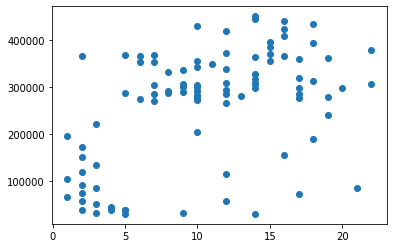

In [ ]:
amount_new_request_15_min_ = np.array(amount_new_request_15_min)[:,1]
print(amount_new_request_15_min_)
env_data_requests_15_min = trips_data[trips_data['dow']==4].groupby('t_15min').n_trips.sum()[0:95]
print(env_data_requests_15_min)
plt.scatter(amount_new_request_15_min_,env_data_requests_15_min)

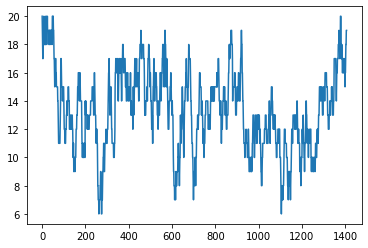

In [ ]:
plt.plot(nb_available_car)

### Test

In [ ]:
score

In [ ]:
state = env.reset()
state['dow']

In [ ]:
v = list_state[30]['v_locs'][1]
v1 = list_state[30]['request_locs'][0][0]
time = list_state[30]['time']
duree_deplacement(v,v1,time)

In [ ]:
list_state[29]['request_times']

In [ ]:
list_state[29]['v_jobs']

In [ ]:
list_state[6]['v_jobs']

In [ ]:
v = new_state['v_locs'][0]
time = new_state['time']
v1 = np.array(env.lots)[i]

In [ ]:
v1

In [ ]:
heuristic(new_state)

In [ ]:
action = env.get_random_action()
action 

In [ ]:
OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([20])), ('req_rejections', array([0]))])